In [15]:
from MEDIC.secrets import controller
from MEDIC.utils.GeoInfoConvertor import get_country_short_name

import pandas as pd
import numpy as np

In [16]:
def get_delta_df(df, target: str):
    df = df.set_index(['date', 'CountryCode'])\
                .unstack(level=-1)\
                .diff(axis=0)\
                .unstack(level=0)\
                .reset_index()\
                .rename(columns={0: target})\
                .drop('level_0', axis=1)\
                .dropna()
    df['date'] = pd.to_datetime(df['date'])

    df.set_index('date')
    df.asfreq('D')

    return df

In [17]:
confirmed_df = controller.get_df_from_sql("select CountryCode, date, confirmed "
                                          "from covid_info.COVID_Cases "
                                          "where SubdivisionCode is null and CountryCode != 'not found'")
print(confirmed_df)
confirmed_df = get_delta_df(confirmed_df, 'confirmed')

deaths_df = controller.get_df_from_sql("select CountryCode, date, deaths "
                                          "from covid_info.COVID_Cases "
                                          "where SubdivisionCode is null and CountryCode != 'not found'")
deaths_df = get_delta_df(deaths_df, 'deaths')

recovered_df = controller.get_df_from_sql("select CountryCode, date, recovered "
                                          "from covid_info.COVID_Cases "
                                          "where SubdivisionCode is null and CountryCode != 'not found'")
recovered_df = get_delta_df(recovered_df, 'recovered')

       CountryCode        date  confirmed
0              AFG  2020-01-22        0.0
1              AFG  2020-01-23        0.0
2              AFG  2020-01-24        0.0
3              AFG  2020-01-25        0.0
4              AFG  2020-01-26        0.0
...            ...         ...        ...
103483         TLS  2021-07-09     9710.0
103484         TLS  2021-07-10     9766.0
103485         TLS  2021-07-11     9823.0
103486         TLS  2021-07-12     9862.0
103487         TLS  2021-07-13     9906.0

[103488 rows x 3 columns]


In [18]:
import matplotlib.pyplot as plt
from numpy.random import randint

In [19]:
confirmed_df

,CountryCode,date,confirmed
1,AFG,2020-01-23,0.0
2,AFG,2020-01-24,0.0
3,AFG,2020-01-25,0.0
4,AFG,2020-01-26,0.0
5,AFG,2020-01-27,0.0
...,...,...,...
103483,ZWE,2021-07-09,2683.0
103484,ZWE,2021-07-10,1787.0
103485,ZWE,2021-07-11,912.0
103486,ZWE,2021-07-12,2661.0


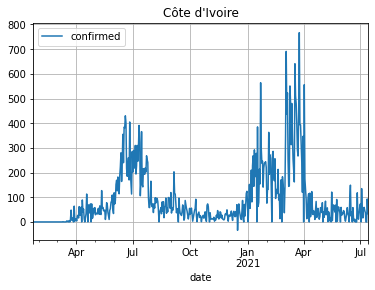

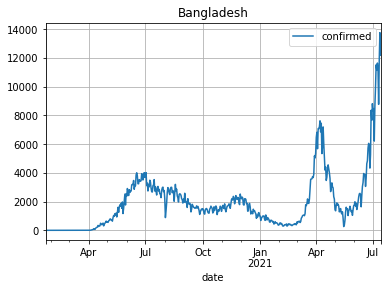

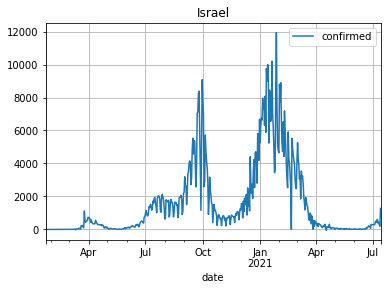

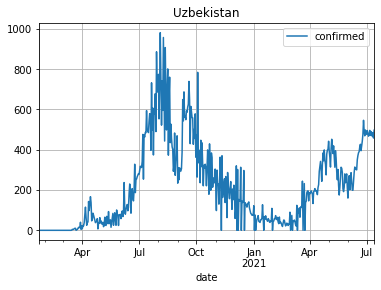

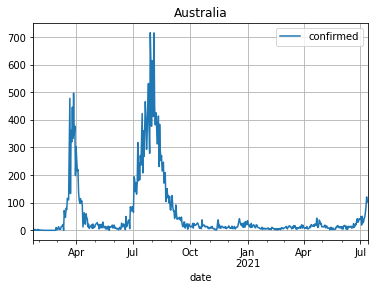

In [20]:
countries = list(set(confirmed_df['CountryCode']))
country_count = len(countries)

for country in map(lambda idx: countries[idx], randint(0, country_count, 5)):
    confirmed_df[confirmed_df['CountryCode'] == country]\
        .plot(x='date',
              y='confirmed',
              title=get_country_short_name(country),
              grid=True
    )


component of Time Series



In [21]:
example_df = confirmed_df[confirmed_df['CountryCode'] == 'GBR']

In [22]:
# Normalisation
def normalise_df(df, column):
    mean = df[column].mean()
    std = df[column].std()
    df.loc[:, column] = (df[column] - mean)/std
    return df

def plot_df(df):
    country = list(set(df['CountryCode']))[0]
    df.plot(x='date',
            y='confirmed',
            title=get_country_short_name(country),
            grid=True
    )

/Users/JohnJongyoonKim/Documents/projects/MEDIC/pyIntp/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


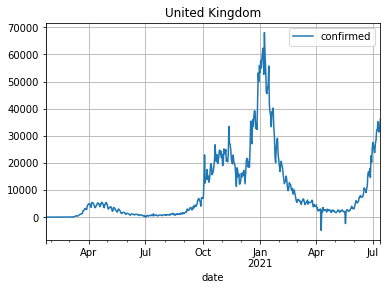

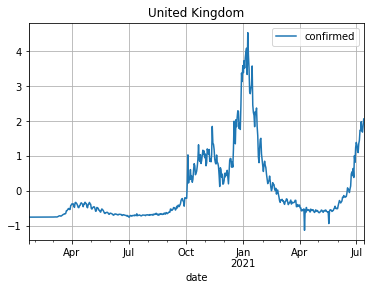

In [23]:
plot_df(example_df)
norm_ex_df = normalise_df(example_df, 'confirmed')
plot_df(norm_ex_df)

### Time series decompositioin
#### Trend
#### Cycle
#### Seasonal
#### Random, Residual

<Figure size 1080x864 with 0 Axes>

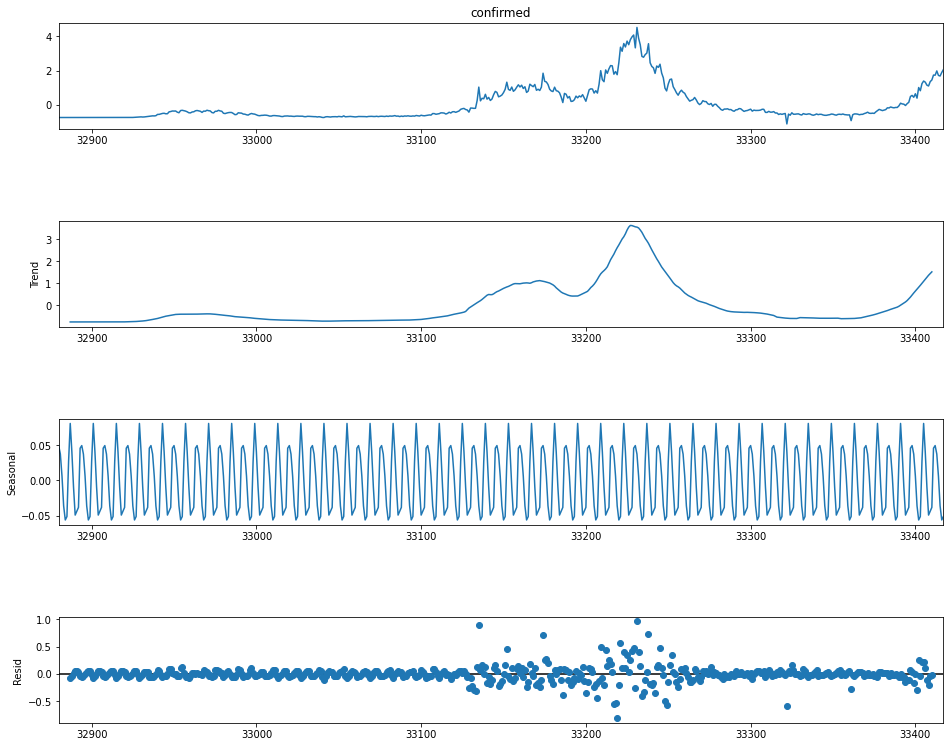

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

# model = 'additive', 'multiplicative'
decomposed = seasonal_decompose(norm_ex_df['confirmed'],
                                model='additive',
                                period=14)

fig = plt.figure(figsize=(15, 12))
fig = decomposed.plot()
fig.set_size_inches(15, 12)


코로나는 14일이 최대 증상 발현 주기이기 때문에 주기를 14일로 설정.

영국의 경우 대부분 기간에서 패턴을 보이지만 20년 겨울~ 21년 봄 사이의 데이터에서 Residual이 경향성 없이 나타난다.


<Figure size 1080x864 with 0 Axes>

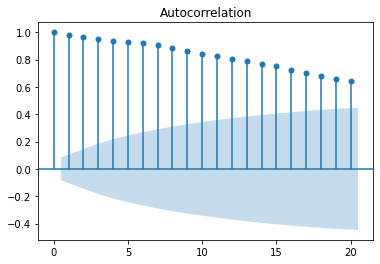

In [25]:
from statsmodels.graphics.tsaplots import plot_acf


fig = plt.figure(figsize=(15, 12))
fig = plot_acf(norm_ex_df['confirmed'], lags=20)

(https://leedakyeong.tistory.com/entry/ARIMA%EB%9E%80-ARIMA-%EB%B6%84%EC%84%9D%EA%B8%B0%EB%B2%95-AR-MA-ACF-PACF-%EC%A0%95%EC%83%81%EC%84%B1%EC%9D%B4%EB%9E%80)
## 정상성
평균, 분산이 시간에 따라 일정한 성
즉, 시계열 데이터의 특성이 시간의 흐름에 따라 변하지 않음을 의미

정상성을 나타내지 않는 데이터는 복잡한 패턴을 모델링하여 분석하기 어렵기 때문에 정상성을 갖도록 로그 변환, 차분 등 전처리 후 분석을 시행.

## 정상성 시계열 변환
1. 변등폭이 일정하지 않은 경우 -> 로그 변환
2. 추세, 계절성이 존재하는 경우 -> 차분 (differencing) -> 정상성을 띌때까지

## ACF (AutoCorrelation Function) 자기 상관 함수
시차에 따른 일련의 자기상관을 의미하며, 시차가 커질수록 ACF는 0에 가까워진다.
정상 시계열은 상대적으로 빠르게 0에 수렴. 비정상 시계열은 천천히 감소.

## ADF (Augmented Dickey-Fuller Test)
* H0 = the data has unit root, no Stationary.
* H' = the data has stationary.


In [26]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(norm_ex_df['confirmed'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.345095
p-value: 0.157836
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


~~~
ADF Statistic: -2.345095
p-value: 0.157836
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570
~~~
정상성 미만족
